> In the directories T1b, T1c, etc you'll find a LCs folder with the light curves (name= channel_number_epoch_aor.txt) and two other folders MCMC_1 and MCMC_2. In MCMC_1 there are the input files of the analyses and the output mcmc_med.res from a global analysis of 2*100000 steps with priors on the stellar parameters set from the value of Van Grootel 2017 and a different depth for channel 1 and 2. In MCMC_2 it is the same except that each transit can have different depths.

> In T1b_occ et T1c_occ it is similar but for occultations, assuming a commun depth.

> In All/MCMC you'll find the input files and the output file mcmc_med.res of an analysis of all the well isolated transits for the seven planets. Michael used 2 chains of 500000 steps and no prior on R* in order to see how the transit could constraint the stellar density. 

> In all_aors there is all the photometry for each AORs.

> And in Blends, you'll find the blended or partial transit that I still have to analyse.


C1 = BJD_UTC-2450000

C2 = flux

C3 = error

C4 = X

C5 = Y

C6 = fwhm

C7 = fwhm-x

C8 = fwhm-y

C9 = background

C10 = airmass, irrelevant here

C11 = exposure time (subarray)

> To model this light curve, I use a linear function of X, Y, fwhm-x, and fwhm-y, plus a transit model.



In [100]:
import numpy as np

all_ttvs = []

for planet in list('bcdefgh'):
    rows = []
    for line in open('trappist1_Spitzer_Michael/T1{0}/MCMC_1/mcmc_med.res'.format(planet)).read().splitlines():
        if line.strip().startswith('Ttr'):
#         if line.strip().startswith('TTV'):
            #rows.append(list(map(float, line.split()[2:-2])))
            rows.append(list(map(float, line.split()[2:-2])))
    ttvs = np.array(rows)[:, 0]
    all_ttvs.append(ttvs)

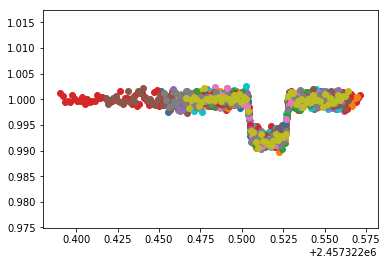

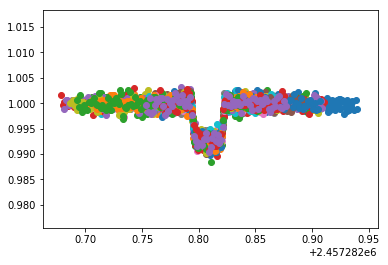

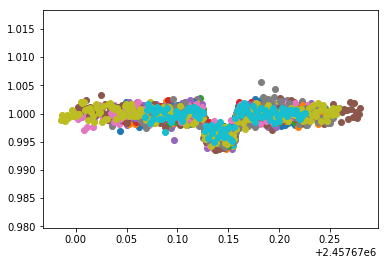

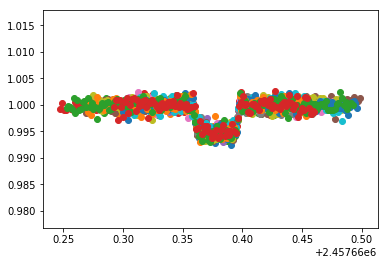

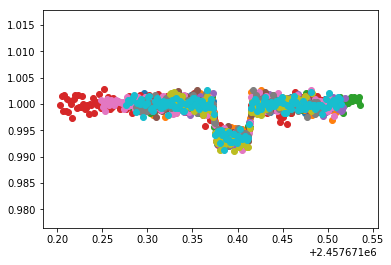

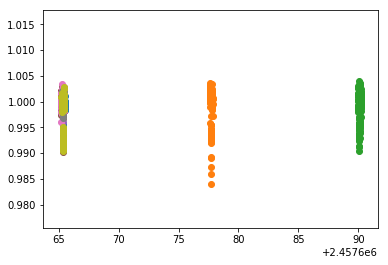

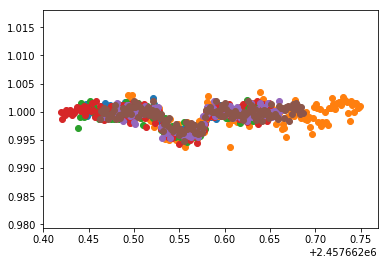

In [144]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/bmmorris/git/libra/')

from glob import glob

from libra import trappist1_all_transits, trappist1, transit_duration

for planet, ttvs in zip(list('bcdefgh'), all_ttvs):

    paths = sorted(glob('trappist1_Spitzer_Michael/T1{0}/LCs/*'.format(planet)))
    for i, path in zip(range(len(paths)), paths):
        bjd, flux, err, x, y, fwhm, fwhmx, fwhmy, bg, airmass, exptime = np.loadtxt(path, unpack=True)
#         bjd += 2450000
#         bjd -= ttv

#         phases = ((bjd - ttv) % trappist1(planet).per)/trappist1(planet).per
#         phases[phases > 0.5] -= 1

        ttv = ttvs[np.argmin(np.abs(bjd.mean() - ttvs))]

        bjd = bjd - ttv + trappist1(planet).t0

#         plt.scatter(bjd, flux)
#     plt.show()
    
        all_transits = trappist1_all_transits(bjd)

        oot = np.all(all_transits == 1, axis=1)

        t = bjd - bjd.mean()
        X_all = np.vstack([t, x, y, fwhmx, fwhmy]).T

#         X_all = np.vstack([x, y, fwhmx, fwhmy, bg]).T


        X = X_all[oot, :]

        omega = np.diag(err[oot]**2)
        omega_inv = np.linalg.inv(omega)

        V = np.linalg.inv(X.T @ omega_inv @ X)
        beta = V @ X.T @ omega_inv @ flux[oot]

        regressed_lc = flux - (X_all @ beta) + 1
        
        np.savetxt('lightcurves/lc_{0}_{1:03d}.txt'.format(planet, i), np.vstack([bjd, regressed_lc]).T)
        plt.scatter(bjd, regressed_lc)
    plt.show()

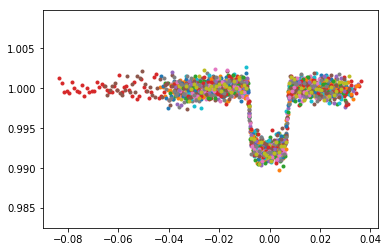

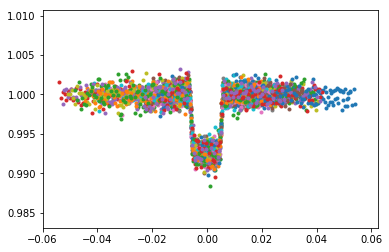

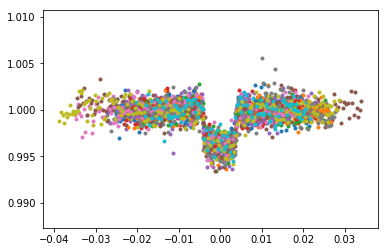

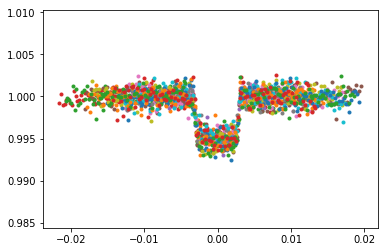

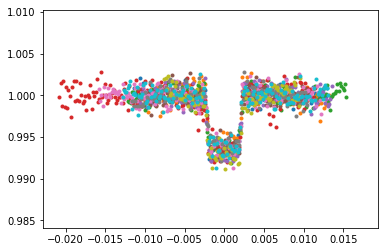

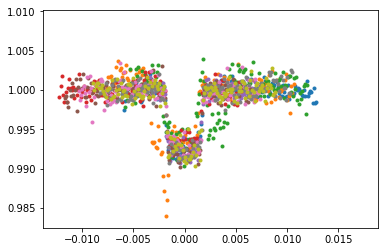

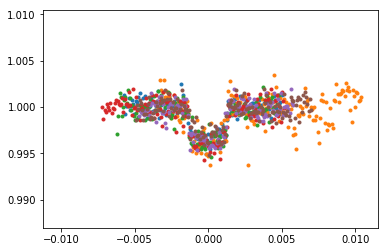

In [145]:
from libra import trappist1

for planet in list('bcdefgh'):
    params = trappist1(planet)

    paths = glob('lightcurves/lc_{0}*'.format(planet))
    phases_all = []
    fluxes_all = []
    for path in paths:
        bjd, fluxes = np.loadtxt(path, unpack=True)
        phases = ((bjd - params.t0) % params.per) / params.per

        phases[phases > 0.5] -= 1

        plt.scatter(phases, fluxes, marker='.')
        phases_all.append(phases)
        fluxes_all.append(fluxes)
        
    np.savetxt('phased/{0}_phased.txt'.format(planet), np.vstack([np.hstack(phases_all), np.hstack(fluxes_all)]).T)

    plt.show()